In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
%matplotlib inline

import sys
sys.path.append('../src/')

import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.optimize import curve_fit, minimize

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

from sklearn.linear_model import LinearRegression

from epsilon_tools import *
from tools import str2date, avg_funs, integrate_columns, first_finite, bandpass_velocity, interp_in_space
from qc import qc_turbulence

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='poster', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)


sns.set(style="ticks", context="talk")
# plt.style.use("dark_background")

In [11]:
def qc_velocity(data):
    '''
    qc EM velocity measurements based on vertical movement and rotation rate of the float
    '''
    Wmin = 0.05
    RotPmax = 20
    verrmax = 0.1 # original 0.02

    # where cond:  what to keep!
    uv_mask = (np.abs(data.W) > Wmin) & (data.RotP < RotPmax)
    u1_mask = uv_mask & (data.verr1 < verrmax)
    u2_mask = uv_mask & (data.verr2 < verrmax)

    data['u1'] = data.u1.where(u1_mask)
    data['u2'] = data.u2.where(u2_mask)
    data['v1'] = data.v1.where(u1_mask)
    data['v2'] = data.v2.where(u2_mask)

    data['u'] = avg_funs(data['u1'], data['u2'])
    data['v'] = avg_funs(data['v1'], data['v2'])
    data['dudz'] = avg_funs(data['du1dz'], data['du2dz'])
    data['dvdz'] = avg_funs(data['dv1dz'], data['dv2dz'])
    data['S2'] = 0.5*( data.dudz**2 + data.dvdz**2 )

    data = data.drop([
        'W', 'RotP', 'verr1', 'verr2', 'u1', 'u2', 'v1', 'v2', 'du1dz',
        'du2dz', 'dv1dz', 'dv2dz'
    ])
    return data

In [14]:
floatid = '7781a'
raw = xr.open_dataset(f'../data/xarray/xr_{floatid}.nc')
cfs = xr.open_dataset('../data/metdata/float_cfs_hourly.nc')
cfs = cfs.sel(floatid=f'{floatid}')
emp = xr.open_dataset('../data/CFS/croppped_emp_field.nc')
raw = qc_turbulence(raw)
raw = qc_velocity(raw)
met = xr.open_dataset('../data/CFS/CFSv2_wind_rh_t_p_2016_2018.nc')

In [25]:
surf = load_matfile('../data/CFS/CFSv2_surf_2016_2018.mat')

In [33]:
dsoc = xr.Dataset({  # define wanted variables here!
        'tx': (['lon', 'lat', 'time'], surf['uflx']),
        'ty': (['lon', 'lat', 'time'], surf['vflx']),
    },
        coords={'lon': surf['Lon'], 'lat':surf['Lat'],
                'time': dn2dt_vec(surf['Jday_gmt'])}
    )

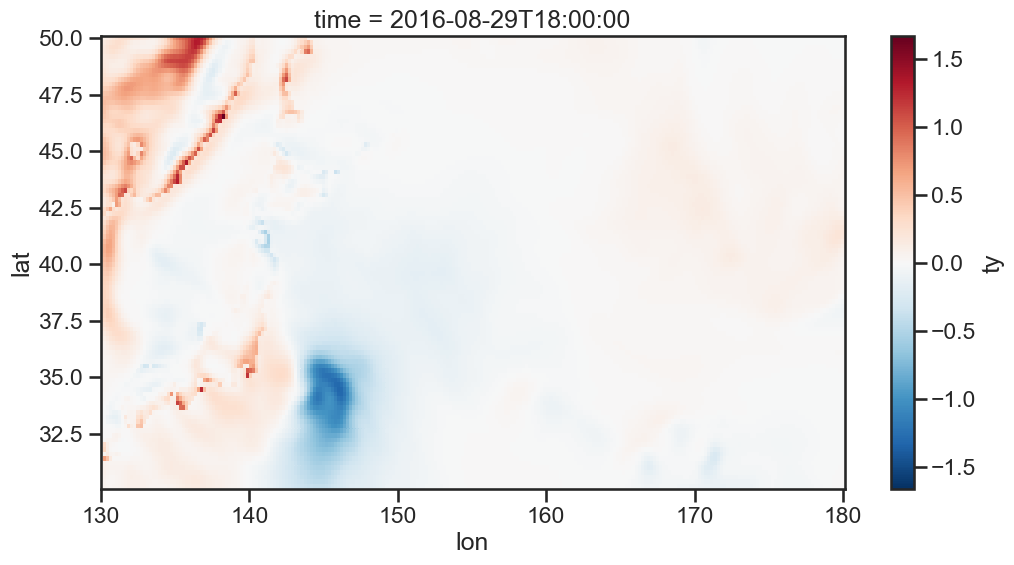

In [38]:
dsoc.ty.interp(time='2016-08-29T18:00:00').plot(x='lon', cmap='RdBu_r');

In [6]:
from tools import load_matfile, datenum2datetime
dn2dt_vec = np.vectorize(lambda x: datenum2datetime(x))

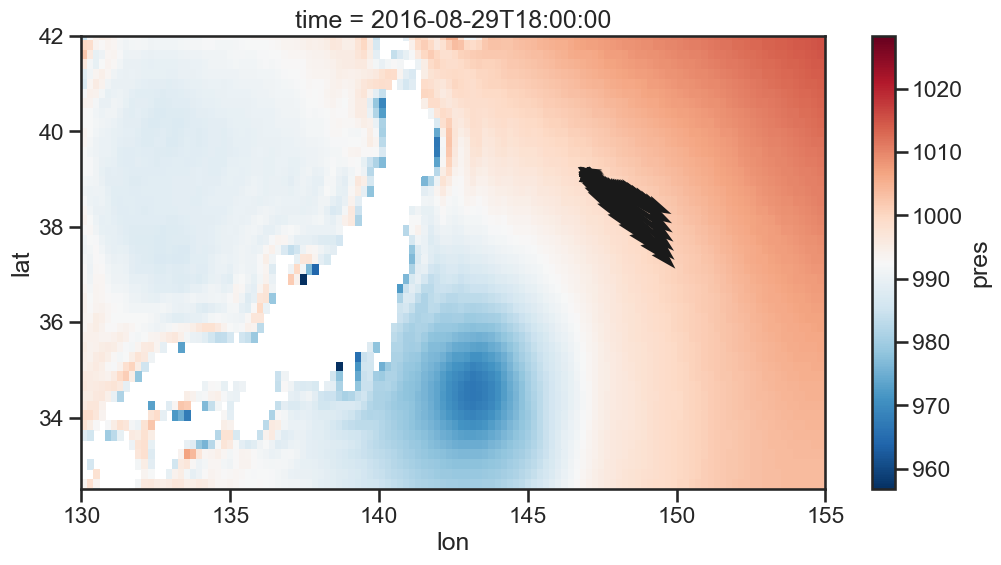

In [15]:
met.pres.interp(time='2016-08-29T18:00:00').plot(x='lon', cmap='RdBu_r')
temp = cfs.sel(time=slice('2016-08-28T18:00:00','2016-08-31T18:00:00'))
plt.quiver(temp.lon,temp.lat, temp.tx, temp.ty)
plt.xlim(130,155)
plt.ylim(32.5,42);

In [1647]:
oc = load_matfile('../data/CFS/CFSv2_ocn_uv_t2m_2016_2018.mat')

In [1648]:
oc['u_ocn'].shape

(60, 40, 14593)

In [1649]:
dsoc = xr.Dataset({  # define wanted variables here!
        'u': (['lon', 'lat', 'time'], oc['u_ocn']),
        'v': (['lon', 'lat', 'time'], oc['v_ocn']),
    },
        coords={'lon': oc['Lon_ocn'], 'lat':oc['Lat_ocn'],
                'time': dn2dt_vec(oc['Jday_gmt_ocn'])}
    )

In [1626]:
dsoc = dsoc.sel(time=slice('2016-10-01','2016-10-21'))

In [1634]:
atmnew = atm.interp_like(dsoc)

In [1635]:
tot = xr.merge([atmnew, dsoc])

In [1396]:
atm = xr.open_dataset('../data/CFS/CFSv2_wind_rh_t_p_2016_2018.nc').sel(time=slice('2016-10-01','2016-10-21'))

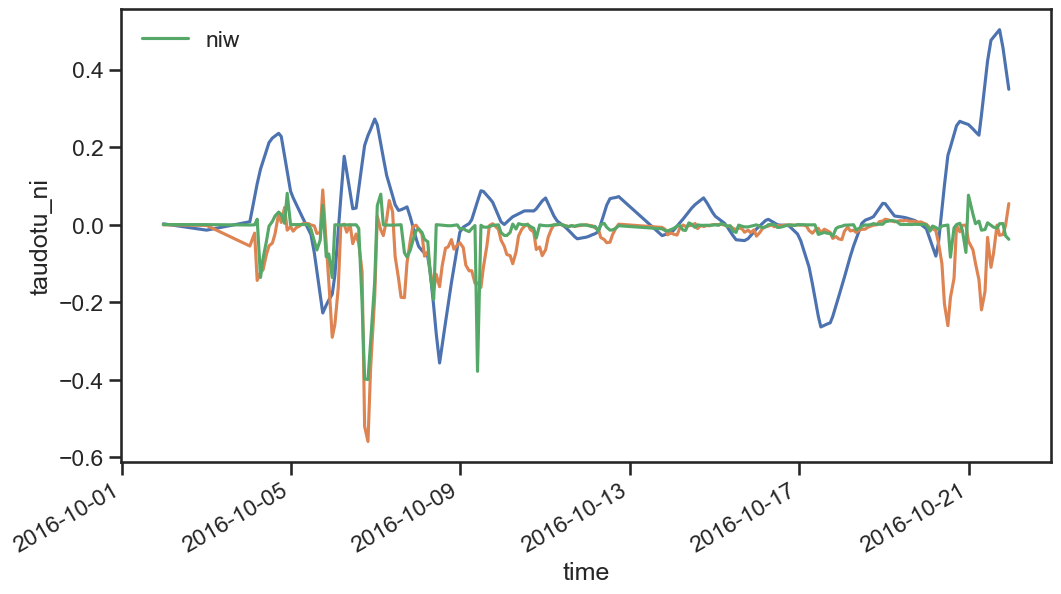

In [1676]:
subset.ty.plot()
subset.taudotu.plot()
raw.sel(time=slice('2016-10-01','2016-10-21')).taudotu_ni.pipe(lambda x: 10*x).plot(label='niw')
plt.legend()

In [1421]:
atm['phase'] = np.arctan2(atm.v10,atm.u10)

In [1448]:
atm['dphase'] = atm.phase.differentiate('time', datetime_unit='s')

In [1457]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [1464]:
def plot_2d(t):
    atm.dphase.isel(time=t).transpose().plot()
    plt.plot(subset.lon,subset.lat, marker='d', markersize=5, color='r')

In [1556]:
import holoviews as hv

In [1570]:
f = gsw.f(40)

In [1677]:
atm.phase.hvplot(x='lon', y='lat', width=500, height=500)+atm.dphase.pipe(lambda x: x/f).hvplot(x='lon', y='lat',cmap='RdBu_r', size=10, width=500, height=500)

:Layout
   .DynamicMap.I  :DynamicMap   [time]
      :Image   [lon,lat]   (phase)
   .DynamicMap.II :DynamicMap   [time]
      :Image   [lon,lat]   (dphase)

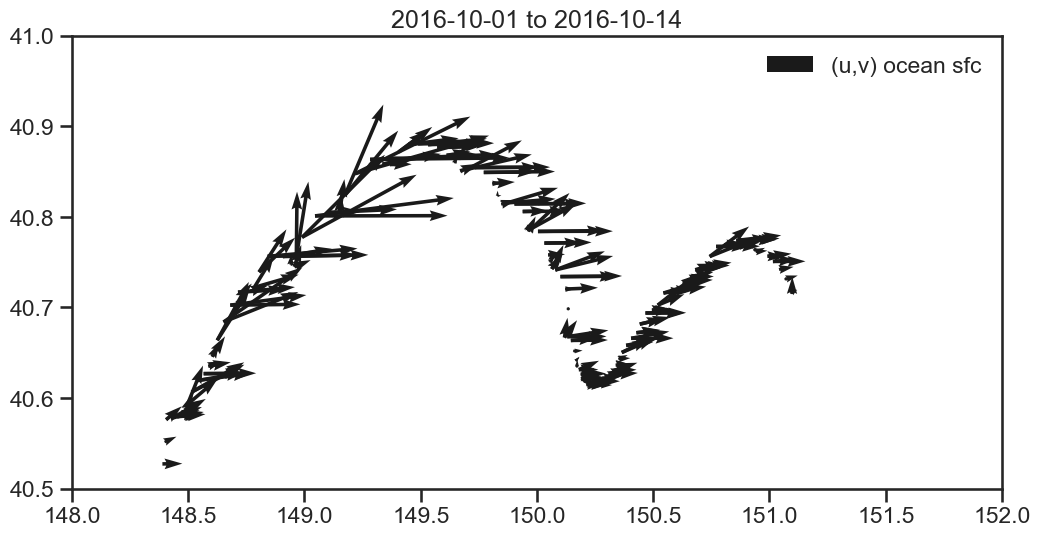

In [1723]:
ang = np.arctan2(subset.v_surf,subset.u_surf)
plt.quiver(subset.lon,subset.lat, subset.u_surf, subset.v_surf, label='(u,v) ocean sfc')
# plt.plot(subset.lon.isel(time=20),subset.lat.isel(time=20), marker='o', markersize=10)
# plt.quiver(subset.lon,subset.lat, -subset.tx, -subset.ty, color='green', alpha=0.2, label=r'(-$\tau_x$,-$\tau_y$)')
# plt.quiver(subset.lon,subset.lat, subset.tx, subset.ty, color='red', alpha=0.2, label=r'($\tau_x$,$\tau_y$)')

temp = cfs.sel(time=slice('2016-10-01','2016-10-21'))
# plt.quiver(temp.lon,temp.lat, temp.tx, temp.ty)

plt.ylim(40.5,41)
plt.xlim(148,152)
plt.title('2016-10-01 to 2016-10-14')
plt.legend()

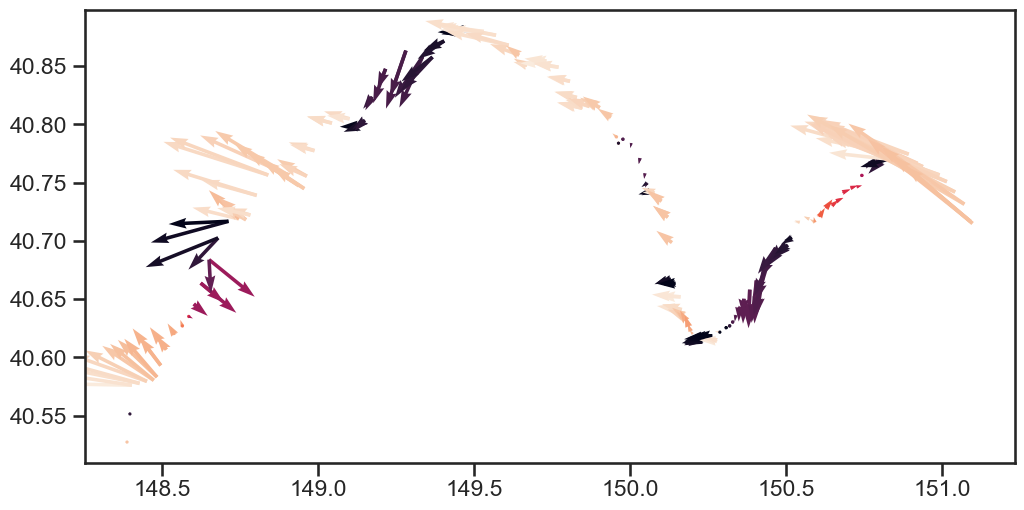

In [1495]:
ang = np.arctan2(subset.ty, subset.tx)
plt.quiver(subset.lon,subset.lat, subset.tx, subset.ty, ang)

In [17]:
def first_finite(arr, axis):
    '''spits out the indices'''
    mask = arr.notnull() & (arr > 0)
    return xr.where(mask.any(axis=axis), mask.argmax(axis=axis), np.nan).fillna(0).astype(int)

In [18]:
raw['mld'] = ('time', raw.z.where(raw.S2 == raw.S2.max(dim='z')).mean(dim='z'))
raw['Ri'] = raw.n2/raw.S2

# extract uppermost velocity measuremnt
indu = first_finite(raw.u, 0).fillna(0).astype(int)
indv = first_finite(raw.v, 0).fillna(0).astype(int)

raw['u_surf'] = raw.u[indu]
raw['v_surf'] = raw.v[indv]

indS = first_finite(raw.S, 0).fillna(0).astype(int)
indT = first_finite(raw.T, 0).fillna(0).astype(int)
raw['S_surf'] = 0.5*(raw.S[indS]+raw.S[indS+1])
raw['T_surf'] = 0.5*(raw.T[indT]+raw.T[indT+1])

In [21]:
emp = emp.sortby('time').resample(time='1h').mean()
emp = emp.interp_like(raw) # interpolates onto floats time
cfs = cfs.interp_like(raw, method='linear')
rho0=raw.rho0.mean()
g = 9.81

uNI, vNI = bandpass_velocity(raw)
raw['uNI'] = uNI.drop('dtime')
raw['vNI'] = vNI.drop('dtime')
raw['hkeNI'] = 0.5*rho0*( raw.uNI**2 + raw.vNI**2)
raw['hkeTOT'] = 0.5*rho0*( raw.u**2 + raw.v**2)

# extract uppermost velocity measuremnt
indu = first_finite(raw.uNI, 0).fillna(0).astype(int)
indv = first_finite(raw.vNI, 0).fillna(0).astype(int)
raw['u_surf_ni'] = raw.uNI[indu]
raw['v_surf_ni'] = raw.vNI[indv]

raw['emp'] = ('time', interp_in_space(raw, emp).EMP)
raw['emp'] = raw.emp/(100*86400)
raw['qnet'] = ('time', cfs['Qnet'])
                                                                                    
raw['tx'] = ('time', -cfs['tx'])
raw['ty'] = ('time', -cfs['ty'])
raw['taudotu'] = raw.u_surf * raw.tx + raw.v_surf * raw.ty
raw['taudotu_ni'] = raw.u_surf_ni * raw.tx + raw.v_surf_ni * raw.ty

raw['tau'] = ('time', np.sqrt( raw.tx**2 + raw.ty**2 ))
raw['uprime'] = np.sqrt( raw.tau/raw.rho0.mean() )
raw['shear_prod'] = -raw.uprime**3/(0.4*raw.z) 
raw['shear_prod'] = raw.shear_prod.transpose('z','time').where( raw.shear_prod<1e5)
# raw['mshear_prod'] = ('time', -integrate_columns(raw.shear_prod, raw.mld))

../src/tools.py:97: UnevenSamplingWarning: Average sampling 9.94e+12 != first sampling step 2.23e+12
  fs = ( dsp.get_sampling_step(raw, dim='time')*1e-9 )


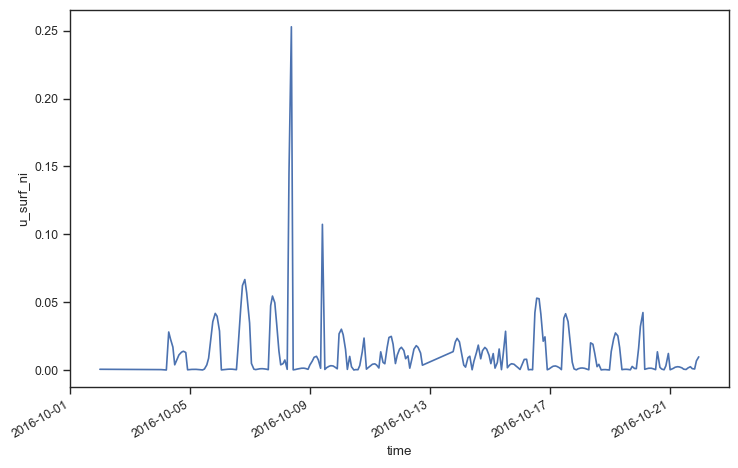

In [42]:
raw['u_surf_ni'].sel(time=slice('2016-10-01','2016-10-21')).plot()

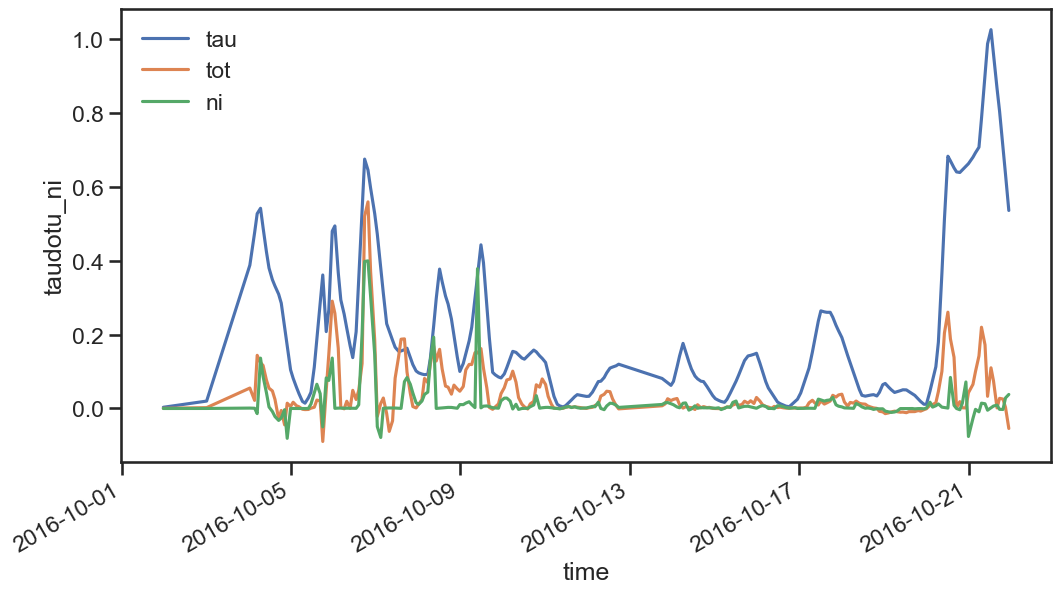

In [39]:
raw.tau.sel(time=slice('2016-10-01','2016-10-21')).plot(label='tau')
raw.taudotu.sel(time=slice('2016-10-01','2016-10-21')).plot(label='tot')
raw.taudotu_ni.pipe(lambda x: x*10).sel(time=slice('2016-10-01','2016-10-21')).plot(label='ni')
plt.legend()